In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext lab_black
%matplotlib inline

In [9]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2516659968480773110
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3156787200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13616420986963603714
physical_device_desc: "device: 0, name: GeForce GTX 980M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [10]:
import tensorflow as tf

tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# U-NET

In [11]:
import numpy as np
import scipy as scipy
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from helpers import *

In [15]:
# Import all the necessary for our model
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Activation,
    Dropout,
    Flatten,
    Dense,
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
)
from tensorflow.compat.v2.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [17]:
from keras_tqdm import TQDMNotebookCallback

# keras, model definition...
cb = TQDMNotebookCallback()
setattr(cb, "on_train_batch_begin", lambda x, y: None)
setattr(cb, "on_train_batch_end", lambda x, y: None)

# model.fit(X_train, Y_train, verbose=0, callbacks=[cb])

Using TensorFlow backend.


# Loading images

In [18]:
# Load a set of images
root_dir = "data/"

# Select the directory for the images and load them
image_dir_train = root_dir + "training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)

print("Loading " + str(n_train) + " images")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)

# Select the directory for groundtruth images and load them
gt_dir_train = root_dir + "training/groundtruth/"
print("Loading " + str(n_train) + " groundtruth images")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

Loading 85 images
Loading 85 groundtruth images


In [19]:
imgs_train.shape

(85, 400, 400, 3)

In [20]:
gt_imgs_train.shape

(85, 400, 400)

In [21]:
image_size = 400

# We separate the images from the groundtruth images
img_patches_train = [
    img_crop(imgs_train[i], image_size, image_size) for i in range(n_train)
]
gt_patches_train = [
    img_crop(gt_imgs_train[i], image_size, image_size) for i in range(n_train)
]

# Linearize the list and labeling them X and Y
X_train = np.asarray(
    [
        img_patches_train[i][j]
        for i in range(len(img_patches_train))
        for j in range(len(img_patches_train[i]))
    ]
)
Y_train = np.asarray(
    [
        gt_patches_train[i][j]
        for i in range(len(gt_patches_train))
        for j in range(len(gt_patches_train[i]))
    ]
)

In [22]:
X_train.shape

(85, 400, 400, 3)

In [23]:
Y_train.shape

(85, 400, 400)

In [24]:
# Select the directory for the images and load them
image_dir_val = root_dir + "validating/images/"
files = os.listdir(image_dir_val)
n_val = len(files)

print("Loading " + str(n_val) + " images")
imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])

# Select the directory for groundtruth images and load them
gt_dir_val = root_dir + "validating/groundtruth/"
print("Loading " + str(n_val) + " groundtruth images")
gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

Loading 15 images
Loading 15 groundtruth images


In [25]:
imgs_val.shape

(15, 400, 400, 3)

In [26]:
gt_imgs_val.shape

(15, 400, 400)

In [27]:
image_size = 400

# We separate the images from the groundtruth images
img_patches_val = [img_crop(imgs_val[i], image_size, image_size) for i in range(n_val)]
gt_patches_val = [
    img_crop(gt_imgs_val[i], image_size, image_size) for i in range(n_val)
]

# Linearize the list and labeling them X and Y
X_val = np.asarray(
    [
        img_patches_val[i][j]
        for i in range(len(img_patches_val))
        for j in range(len(img_patches_val[i]))
    ]
)
Y_val = np.asarray(
    [
        gt_patches_val[i][j]
        for i in range(len(gt_patches_val))
        for j in range(len(gt_patches_val[i]))
    ]
)

In [28]:
X_val.shape

(15, 400, 400, 3)

In [29]:
Y_val.shape

(15, 400, 400)

# Generating mini-batch and running data augmentation

In [30]:
def create_minibatch(X, Y, n):

    # Fix the seed
    np.random.seed(1)

    # We define the window size of 72, batch size of 100 (empirically chosen)
    # and patch size should correspond to 16
    w_size = 64
    batch_size = 100
    patch_size = 16
    num_images = n

    while True:
        # Generate one minibatch
        batch_image = np.empty((batch_size, w_size, w_size, 3))
        batch_label = np.empty((batch_size, 2))

        for i in range(batch_size):

            # Select a random index represnting an image
            random_index = np.random.choice(num_images)

            # Width of original image
            width = 400

            # Sample a random window from the image
            random_sample = np.random.randint(w_size // 2, width - w_size // 2, 2)

            # Create a sub image of size 72x72
            sampled_image = X[random_index][
                random_sample[0] - w_size // 2 : random_sample[0] + w_size // 2,
                random_sample[1] - w_size // 2 : random_sample[1] + w_size // 2,
            ]

            # Take its corresponding ground-truth image
            correspond_ground_truth = Y[random_index][
                random_sample[0] - patch_size // 2 : random_sample[0] + patch_size // 2,
                random_sample[1] - patch_size // 2 : random_sample[1] + patch_size // 2,
            ]

            # We set in the label depending on the threshold of 0.25
            # The label becomes either 0 or 1 by applying to_categorical with parameter 2
            label = to_categorical(
                (np.array([np.mean(correspond_ground_truth)]) > 0.25) * 1, 2
            )

            # The image augmentation is based on both flipping and rotating (randomly in steps of 45°)
            # Random vertical and horizontal flip
            if np.random.choice(2) == 1:
                sampled_image = np.flipud(sampled_image)

            if np.random.choice(2) == 1:
                sampled_image = np.fliplr(sampled_image)

            # Random rotation in steps of 45°
            rotations = [0, 45, 90, 135, 180, 225, 270, 315]

            # We select a rotation degree randomly
            rotation_choice = np.random.choice(len(rotations))

            # Rotate it using the random value (uses the scipy library)
            sampled_image = scipy.ndimage.rotate(
                sampled_image,
                rotations[rotation_choice],
                order=1,
                reshape=False,
                mode="reflect",
            )

            # We put in the sub image and its corresponding label before yielding it
            batch_image[i] = sampled_image
            batch_label[i] = label

        # Yield the mini_batch to the model
        yield (batch_image, batch_label)

# Creating the class (Same as in resnet_unet_model.py, but provided here for better readability)

In [31]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [32]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [33]:
class resnet_unet_model:

    # Initialize the class
    def __init__(self, shape, batch_normalization, activation):
        self.shape = shape
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.model = self.initialize_resnet_unet_model(
            shape, batch_normalization, activation
        )

    def conv_act(self, inputs, out_filters, activation="relu"):
        return Conv2D(
            filters=out_filters,
            activation=activation,
            kernel_size=3,
            strides=1,
            padding="same",
        )(inputs)

    def decoder(
        self,
        inputs,
        mid_filters=512,
        out_filters=256,
        activation="relu",
        block_name="decoder",
    ):
        with K.name_scope(block_name):
            conv = self.conv_act(inputs, mid_filters, activation)
            conv_tr = Conv2DTranspose(
                filters=out_filters,
                activation=activation,
                kernel_size=4,
                strides=2,
                padding="same",
            )(conv)
        return conv_tr

    def initialize_resnet_unet_model(self, shape, batch_normalization, activation):
        #         print(activation)

        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define parameters
        max_pooling_size = 2
        max_pooling_strd = 2

        # Load a pretrained ResNet
        num_classes = 2
        resnet50 = ResNet50(
            include_top=False,
            weights="imagenet",
            classes=num_classes,
            input_shape=shape,
        )
        resnet50.compile(optimizer=Adam(lr=1e-3), loss="binary_crossentropy")

        # ResNet convolution outputs
        conv5_out = resnet50.get_layer("conv5_block3_out").output
        conv4_out = resnet50.get_layer("conv4_block6_out").output
        conv3_out = resnet50.get_layer("conv3_block4_out").output
        conv2_out = resnet50.get_layer("conv2_block3_out").output

        pool = MaxPooling2D(max_pooling_size, strides=max_pooling_strd, padding="same")(
            resnet50.get_output_at(0)
        )
        dec_center = self.decoder(
            pool,
            mid_filters=shape[0] * 2,
            out_filters=shape[0],
            block_name="decoder_center",
        )
        cat1 = Concatenate()([dec_center, conv5_out])
        dec5 = self.decoder(
            cat1,
            mid_filters=int(shape[0] * 2),
            out_filters=int(shape[0]),
            block_name="decoder5",
        )
        cat2 = Concatenate()([dec5, conv4_out])
        dec4 = self.decoder(
            cat2,
            mid_filters=int(shape[0] * 2),
            out_filters=int(shape[0]),
            block_name="decoder4",
        )
        cat3 = Concatenate()([dec4, conv3_out])
        dec3 = self.decoder(
            cat3,
            mid_filters=int(shape[0]),
            out_filters=int(shape[0] // 4),
            block_name="decoder3",
        )
        cat2 = Concatenate()([dec3, conv2_out])
        dec2 = self.decoder(
            cat2,
            mid_filters=int(shape[0] // 2),
            out_filters=int(shape[0] // 2),
            block_name="decoder2",
        )
        dec1 = self.decoder(
            dec2,
            mid_filters=int(shape[0] // 2),
            out_filters=int(shape[0] // 8),
            block_name="decoder1",
        )
        dec0 = self.conv_act(dec1, out_filters=int(shape[0] // 8))
        conv_f = Conv2D(1, 1, activation="sigmoid", padding="same")(dec0)
        flatten_0 = Flatten()(conv_f)
        dense_0 = Dense(
            shape[0] / 2,
            kernel_regularizer=l2(0.000001),
            activity_regularizer=l2(0.000001),
        )(flatten_0)
        lk_relu_0 = LeakyReLU(alpha=0.1)(dense_0)
        dropout_0 = Dropout(0.5)(lk_relu_0)
        dense_1 = Dense(
            2, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001)
        )(dropout_0)
        output = Activation("sigmoid")(dense_1)

        model = Model(inputs=resnet50.get_input_at(0), outputs=output)

        # Compile the model using the binary crossentropy loss and the Adam optimizer for it
        # We used the accuracy as a metric, but F1 score is also a plausible choice
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=0.001),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):

        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="val_loss", min_delta=0, patience=10, verbose=1, mode="auto"
        )

        # Reduce learning rate on plateau after 4 steps
        lr_callback = ReduceLROnPlateau(
            monitor="loss", factor=0.5, patience=4, verbose=1, mode="auto"
        )

        # Place the callbacks in a list to be used when training
        #         callbacks = [cb, early_stopping, lr_callback]
        callbacks = [early_stopping, lr_callback]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(X_train, Y_train, n_train),
            steps_per_epoch=100,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            validation_data=create_minibatch(X_val, Y_val, n_val),
            validation_steps=100,
        )

    def classify(self, X):
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=28)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return group_patches(predictions, X.shape[0])

    def load(self, filename):
        # Load the model (used for submission)
        dependencies = {"recall": recall, "f1": f1}
        self.model = load_model(filename, custom_objects=dependencies)

    def save(self, filename):
        # Save the model (used to then load to submit)
        self.model.save(filename)

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
# We define the number of epochs and steps per epochs
EPOCHS = 200
# STEPS_PER_EPOCH = 150
batch_normalization = False
activation = "LeakyReLU"
model = resnet_unet_model(
    shape=(64, 64, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model
history = model.train()
model.save("resnet_unet.h5")

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [ ]:
# history.history["loss"]
print(history.history.keys())

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

3


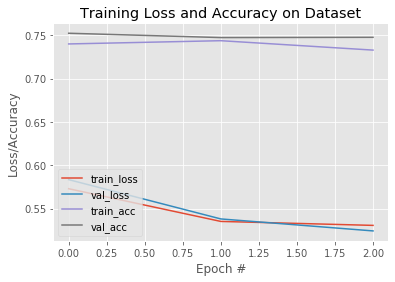

<Figure size 432x288 with 0 Axes>

In [32]:
# plot the training loss and accuracy
N = EPOCHS
print(N)
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("model1.png")

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
batch_normalization = False
activation = "relu"
model = resnet_unet_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
model.train()
model.save("no_batch_relu_validation.h5")

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
batch_normalization = True
activation = "LeakyReLU"
model = resnet_unet_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
model.train()
model.save("batch_LeakyReLU_validation.h5")

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
batch_normalization = True
EPOCHS = 200

activation = "relu"
model = resnet_unet_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
history = model.train()
model.save("batch_relu_validation_200.h5")

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
print(N)
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("batch_relu_validation_200.png")

In [ ]:
from helpers import *

# from resnet_unet_model import resnet_unet_model

# Instantiate the model
batch_normalization = True
activation = "relu"
model = resnet_unet_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load("batch_relu_validation_200.h5")

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "batch_relu_val_200.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

In [ ]:
model.train.